# TP - EigenFaces - MTH3302

___


L'objectif de ce TP est d'explorer l'utilisation de l'analyse en composantes principales pour la reconnaissance faciale.

L'approche utilisée dans ce TP traite les images en tant qu'objects 2D caractérisés par l'ensemble des pixels qui les constituent.

_**Remarque: Nous utilisons la version 1.1.0 de Julia.**_



### Sommaire:
___

**[I.Transormer les données d'entrée](#section_I)**   
**[II.Analyse en composantes principales](#section_II)**  
 [II.1. Calcul des vecteurs propres](#section_II.1)   
 [II.2.Selection des EigenFaces](#section_II.2)  
 [II.3.Visage moyen et EigenFaces](#section_II.3)  
**[III. Reconstruction de l'image en utilisant les EigenFaces](#section_III)**  
**[IV. Reconnaitre les visages de l'ensemble test](#section_IV)**  
  [IV.1. Méthode 1: calcul du seuil avec une expression analytique](#section_IV.1)  
  [IV.2. Méthode 2: calcul du seuil par validation croisée](#section_IV.2)  
**[V. Autres utilisations de la PCA dans la vision par ordinateur](#section_V)**  
**[VI. Références](#section_VI)**  





<a id="section_I"></a>
### I. Transformer les données d'entrée
___

Nous utiliserons des images récupérées de la base de données publique de $Yale^{(1)}$ que vous pouvez trouver sur Moodle. Nous avons choisi les 2 ensembles de sorte à ce que l'ensemble test contient des images déjà vues dans l'ensemble d'entrainement et d'autres tout-à-fait nouvelles. L'objectif final est de mesurer la performance de notre algorithme en comptant le nombre d'exemples bien classifiés.

Commençons par télécharger tous les packages nécessaires:

In [1]:
using ImageMagick
using DocStringExtensions
using PyPlot
using Images
using Netpbm
using Statistics
using LinearAlgebra
using DataStructures
using Printf
using Base.Filesystem
using StatsBase
using Distances
using Random

*Données d'entrainement et de test:*
___

Nous récupérons ensuite les noms des fichiers qui font partie de l'ensemble d'entrainement et celui de test dans les 2 listes "train" et "test" (les 2 dossiers Train et Test peuvent être trouvés sur Moodle).

**Les données d'entrainement:**
Elles contiennent 784 images de 28 personnes différentes, soient 28 images par personne.


**Les données de test:**
Elles contiennent 69 images dont 17 images appartiennent à des personnes qui n'existent pas dans les données d'entrainement et 52 images correspondent à des nouvellles photos des personnes existant dans l'ensemble d'entrainement.

In [2]:
test = readdir("Test")
train = readdir("Train")

784-element Array{String,1}:
 "yaleB01_P00A+000E+00.pgm"
 "yaleB01_P00A+000E+20.pgm"
 "yaleB01_P00A+000E+45.pgm"
 "yaleB01_P00A+000E-20.pgm"
 "yaleB01_P00A+000E-35.pgm"
 "yaleB01_P00A+005E+10.pgm"
 "yaleB01_P00A+010E+00.pgm"
 "yaleB01_P00A+010E-20.pgm"
 "yaleB01_P00A+015E+20.pgm"
 "yaleB01_P00A+020E+10.pgm"
 "yaleB01_P00A+020E-10.pgm"
 "yaleB01_P00A+020E-40.pgm"
 "yaleB01_P00A+025E+00.pgm"
 ⋮                         
 "yaleB29_P00A+050E+00.pgm"
 "yaleB29_P00A-005E+10.pgm"
 "yaleB29_P00A-005E-10.pgm"
 "yaleB29_P00A-010E-20.pgm"
 "yaleB29_P00A-015E+20.pgm"
 "yaleB29_P00A-020E+10.pgm"
 "yaleB29_P00A-020E-10.pgm"
 "yaleB29_P00A-020E-40.pgm"
 "yaleB29_P00A-025E+00.pgm"
 "yaleB29_P00A-035E+15.pgm"
 "yaleB29_P00A-035E+40.pgm"
 "yaleB29_P00A-035E-20.pgm"

Nous créons ainsi la fonction *lireimages* qui permet de lire les images en prenant en argument une liste des noms des images (parmi les deux listes créées dans l'étape précédente).

Cette fonction permet de passer la représentation matricielle d'une image en tant qu'une matrice à N1 lignes et N2 colonnes à un vecteur de taille $N1*N2$ ($N1*N2$ pixels).
Ainsi, cette fonction retourne un tableau qui contient tous les vecteurs obtenus (rappelons nous que chaque vecteur représente une image) ainsi que la taille de chaque image (= nombre de lignes et de colonnes) et le nombre total des images).

Ainsi, chaque image sera transformée de la manière suivante puis nous combinons tous les vecteurs pour former une matrice de taille ($N1*N2)*M$  où $M$ est le nombre d'images dont nous disposons.

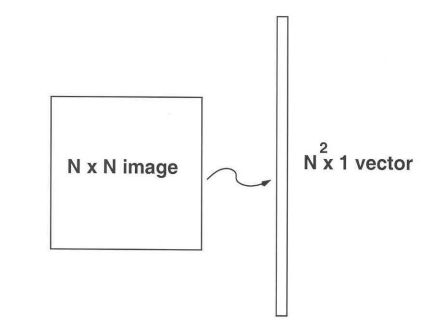

In [3]:
"""
lireimages: transformer les images dont les noms
            figurent dans "noms_images" en vecteurs
input : - noms_images: liste des noms
output: - data: tableau qui contient tous les
                vecteurs-images
        - dimvisage : tableau contenant les dimensions
                du visage N1 * N2
        - n : nombre entier = nombre des images
"""
function lireimages(noms_images)
  dimvisage =[192 168] # dimension du visage souhaitée
  n=length(noms_images) # nmbre des images
  i=1
  data=zeros(n,dimvisage[1]*dimvisage[2]) # initialisation du tableau data
  for i = 1:length(noms_images)
        im=load("ALL/"*noms_images[i]) # importer l'image n°i
        im=convert(Array{Float64},channelview(im)) # convertir l'image en array
        data[i,:] = im[:] # im[:] est un vecteur de taille 192*168 = 32256
  end
  return data::Array{Float64,2},dimvisage::Array{Int},n::Int
end

lireimages

Chaque image est tranformée en une liste de valeurs des pixels de l'image:

In [4]:
lireimages(train)

([80.0 81.0 … 14.0 11.0; 94.0 87.0 … 9.0 8.0; … ; 5.0 6.0 … 141.0 136.0; 5.0 5.0 … 223.0 221.0], [192 168], 784)

In [5]:
size(lireimages(train)[1])

(784, 32256)

<a id="section_II"></a>
### II. Analyse en composantes principales
___

<a id="section_II.1"></a>
#### II.1. Calcul des vecteurs propres:
___

Les vecteurs-images récupérés dans la partie précédente ont une grande taille (192 * 168 = 32256), ce qui pose un problème dans la reconnaissance faciale. La réduction de dimension permettra de contourner ce genre de problème. L'analyse en composantes principales est adaptée à ce problème puisqu'il y a des structures qui caractérisent les visages, ce qui peut être aussi vu comme des directions qui maximisent la variance.



Appelons $\Gamma_i$ le vecteur (de taille $N1*N2$) qui correspond à l'image $i$. Nous allons ensuite$^{(2)}$:

- Calculer le vecteur du visage moyen : $\Psi = \frac{1}{M} \sum_{i=1}^{n} \Gamma_i$
- Centrer les visages : $\Phi_i = \Gamma_i - \Psi$
- Définir la matrice : $A = [ \Phi_1 \Phi_2 .. \Phi_n]$
- Calculer la matrice de covariance de A : $ C = A A^T = \frac{1}{M} \sum_{i=1}^{n} \Phi_i \Phi_i^T$
- Calculer les vecteurs propres $u_i$ de $C$. Nous savons alors que chaque image de l'ensemble d'entrainement peut être écrite sous la forme suivante: $\Gamma_i - \Psi = \Phi_i =  \sum_{j=1}^{n} \omega_j u_j $  où  $\omega_j = u_j^T \Phi_i$.
- Garder les $K$ vecteurs propres qui permettent d'expliquer un pourcentage $P$ de la variance. Ces vecteurs propres sont ce qu'on appelle les "EigenFaces". Ces $K$ EigenFaces sont les directions qui maximise la variance pour les images d'entrainement.

Nous pourrons alors approximer chaque visage de l'ensemble d'entrainement par : $\Gamma_i \simeq \Psi + \sum_{j=1}^{K} \omega_j u_j $, avec : $\omega_j = u_j^T \Phi_i$.



Nous créons alors la fonction *decomppca* qui permet de calculer le visage moyen ainsi que les vecteurs et les valeurs propres de C et un tableau de variance cumulée (donc la ième valeur de ce tableau représente la somme des variances expliquées par les i premiers vecteurs propres).

**Remarque:**   

Notez bien que nous utilisons la décomposition en valeurs singulières pour trouver les vecteurs/ valeurs propres de C. En effet, le paragraphe suivant explique la relation entre les 2$^{(3)}$ :



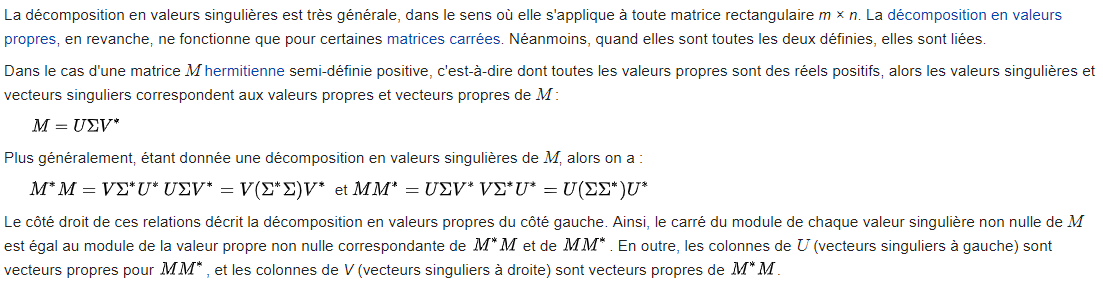

In [6]:
"""
decomppca: performe la PCA
input : - data: vecteurs-images
output: - U: les vecteurs propres
        - lambda : les valeurs propres
        - psi: le visage moyen
        - cumvar : variance cumulée
"""
function decomppca(data::Array{Float64,2})
  data = data' # prendre la transposé car A = transpose(data)
  psi = mean(data,dims = 2) # calculer le visage moyen
  data_hat = data.-psi # centrer les vecteurs-visages
  U,s,_= svd(data_hat) # décomposition en valeurs singulières
  L=length(s)
  lambda = s.^2 # calculer les valeurs propres
  S = sum(lambda)
  cumvar = cumsum(lambda)./S
    
  return U::Array{Float64,2},lambda::Array{Float64,1},psi::Array{Float64,2},cumvar::Array{Float64,1}
end

decomppca

In [7]:
train_set,facedim,n = lireimages(train);

In [8]:
U, lambda, psi, cumvar = decomppca(train_set);

In [9]:
size(U)

(32256, 784)

<a id="section_II.2"></a>
#### II.2. Selection des EigenFaces:
___

Traçons le graphe de la variance cumulée:

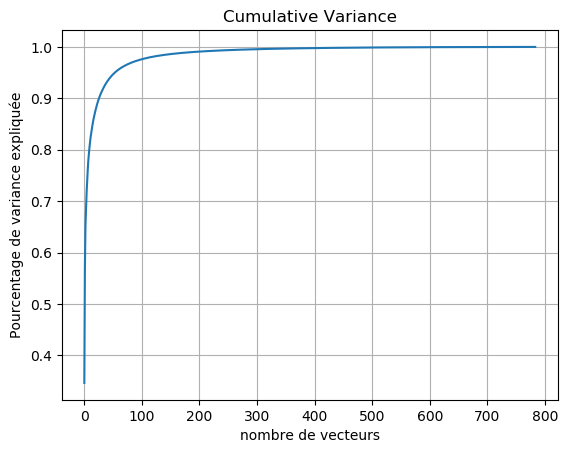

PyObject Text(0.5,1,'Cumulative Variance')

In [10]:
# plot cumulative variance
figure()
plot(cumvar)
xlabel("nombre de vecteurs"); ylabel("Pourcentage de variance expliquée")
grid("on")
title("Cumulative Variance")

Nous remarquons que nous pouvons expliquer un pourcentage presque égal à 100% de la variance aver presque 200 vecteurs propres. Nous définissons la fonction *nbreigenfaces* qui permet d'obtenir le nombre $K$ des vecteurs propres qui permettra d'expliquer 80% / 95% de la variance.


In [11]:
"""
nbreigenfaces: calculer le nombre des EigenFaces
               à garder
input : - data: vecteurs-images
output: - U: les vecteurs propres
        - lambda : les valeurs propres
        - psi: le visage moyen
        - cumvar : variance cumulée
"""
function nbreigenfaces(cumvar::Array{Float64,1})
  N80=findall(cumvar.>0.8)
  n80=findmin(N80)[1]
  N95=findall(cumvar.>0.95)
  n95=findmin(N95)[1]
  return n80::Int,n95::Int
end

nbreigenfaces

In [12]:
n80, n95 = nbreigenfaces(cumvar)

(10, 54)

Nous devrons utiliser les 10 premiers vecteurs propres pour expliquer 80% de la variance des données, et 54 vecteurs propres afin d'expliquer 95% de la variance.

<a id="section_II.3"></a>
#### II.3. Visage moyen et EigenFaces:
___

Définissons la fonction *displayfaces* qui permet d'afficher le visage moyen et les 10 premiers EigenFaces:

In [13]:
"""
displayfaces: afficher le visage moyen
              et les 10 premiers EigenFaces
            
input : - U: vecteurs propres
output: - psi: le visage moyen
        - facedim : la dimension d'un visage
"""
function displayfaces(U::Array{Float64,2},psi::Array{Float64,2},facedim::Array{Int})
  im=reshape(psi,facedim[1],facedim[2])
  figure()
  imshow(im,"gray")
  axis("off")
  figure()
  for i=1:10
    subplot(2,5,i)
    im=U[:,i]
    Im=reshape(im,facedim[1],facedim[2])
    imshow(Im,"gray")
    axis("off")
  end
end

displayfaces

Le 1ère image représente le visage moyen de l'ensemble d'entrainement et les 10 images qui suivent sont les 10 premiers EigenFaces (les 10 vecteurs propres avec les plus grandes valeurs propres):

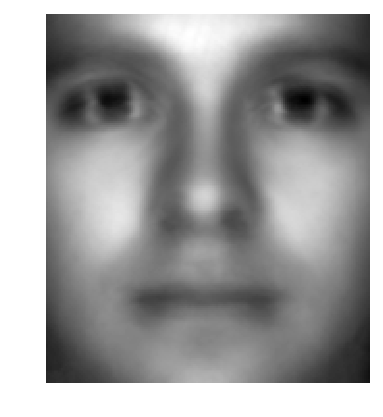

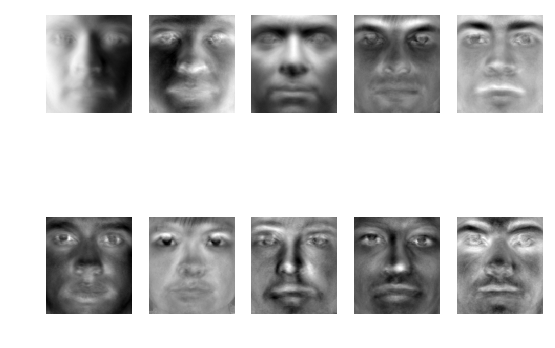

In [14]:
displayfaces(U,psi,facedim)

<a id="section_III"></a>
### III. Reconstruction de l'image en utilisant les EigenFaces
___

Nous avons vu dans la partie précédente que nous pouvons approximer chaque visage de l'ensemble d'entrainement par : $\Gamma_i \simeq \Psi + \sum_{j=1}^{K} \omega_j u_j $, où : $\omega_j = u_j^T \Phi_i$ et $K$ et le nombre des vecteurs propres retenus pour expliquer une variance $P$ donnée.

Pour la reconstruction d'un visage donné de l'ensemble d'entrainement, nous allons d'abord les poids $\omega_j$ en projetant ce visage $\Gamma_i$ (après l'avoir centré) dans l'espace des EigenFaces $\{u_1, .., u_K\}$. Puis, nous allons utilisée la formule précédente pour reconstruire l'image à partir des K EigenFaces.

Nous définissons par la suite les 3 fonctions suivantes:

- La fonction *getface* permet de récupérer un visage avec un indice donné de l'ensemble d'entrainement.
- La fonction *getweights* permet de retourner un tableau qui contient les poids en prenant en entrée un visage donnée.
- La fonction *reconstructface* 

**Remarque:**  

Notez bien que nous ne forçons la positivité des poids calculés dans la fonction *getweights*. Cependant, certaines références indiquent que les résultats obtenus dans ce cas peuvent ne pas être réaliste $^{(4)}$. La raison pour laquelle nous ne forçons pas la positivité est purement empirique. La qualité de la reconstruction de l'image diminue ainsi.

In [15]:
"""
getface: Récupérer un visage pour un indice donné
            
input : - data : tableau des vecteurs-images
        - facedim: dimensions du visage
        - n : indice du visage à récupérer
output: 
        - face : visage d'indice n
"""

function getface(data::Array{Float64,2},facedim::Array{Int},n::Int)
  data=data'
  face=reshape(data[:,n],facedim[1],facedim[2]) #  redimensionner le vecteur (visage) en une array(192*168)
  return face::Array{Float64,2}
end

getface (generic function with 1 method)

In [16]:
"""
getweights: calculer les poids de la projection
            d'un visage dans l'espace des EigenFaces
            
input : - faceim : image d'un visage
        - U: vecteurs propres
        - psi: visage moyen
        - n : nombre des vecteurs propres à retenir
output: 
        - weights : vecteur des poids associés
                    au K vecteurs propres
"""
function getweights(faceim::Array{Float64,2},U::Array{Float64,2},psi::Array{Float64,2},n::Int)
    weights = U[:,1:n]'*(faceim[:]-psi) # calcul des poids
    return weights::Array{Float64,2}
end

getweights

In [17]:
"""
reconstructface: Reconstruire une image de train_set
            
input : - faceim : image d'un visage
        - U: vecteurs propres
        - psi: visage moyen
        - n : nombre des vecteurs propres à retenir
output:
        - weights : vecteur des poids associés
                    au K vecteurs propres
"""

function reconstructface(faceim::Array{Float64,2},U::Array{Float64,2},psi::Array{Float64,2},n::Int)
  weights = getweights(faceim,U,psi,n)
  recon = U[:,1:n]*weights+psi
  recon = reshape(recon,size(faceim))
  return recon::Array{Float64,2}
end

reconstructface (generic function with 1 method)

#### Reconstruction d'un visage aléatoire:
___

Récupérons maintenant le visage d'indice 50 (aléatoire) de l'ensemble d'entrainement:

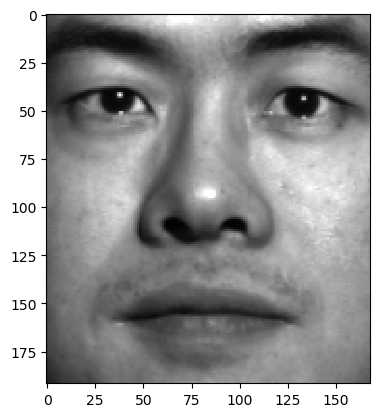

PyObject <matplotlib.image.AxesImage object at 0x7fba82af2f60>

In [18]:
index = 50
rand_face = getface(train_set,facedim,index)
imshow(rand_face,"gray")

Nous faisons la reconstruction des images à partir le résultat de sa reconstruction à partir des EigenFaces:

- En utilisant les vecteurs propres expliquant 95% de la variance

- En utilisant les vecteurs propres expliquant 80% de la variance

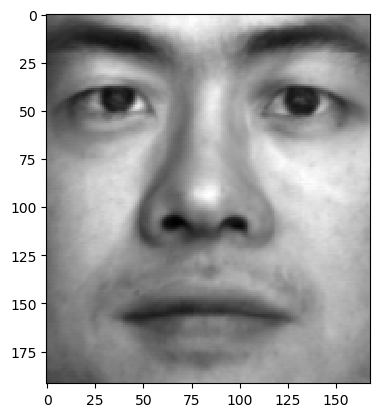

PyObject <matplotlib.image.AxesImage object at 0x7fba82a52e48>

In [19]:
# Avec 95% de la variance
imshow(reconstructface(rand_face,U,psi,n95),"gray")

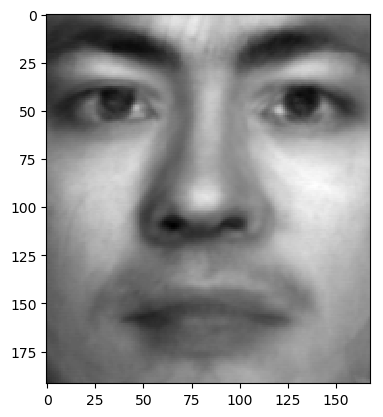

PyObject <matplotlib.image.AxesImage object at 0x7fba82a3c320>

In [20]:
# Avec 80% de la variance
imshow(reconstructface(rand_face,U,psi,n80),"gray")

Nous remarquons qu'il n'y a une légère différence entre la reconstruction utilisant 95% de la variance et celle de 80% variance. Nous travaillerons à partir de ce moment avec n95.

<a id="section_IV"></a>
### IV. Reconnaitre les visages de l'ensemble test   
___

Soit un nouveau visage $\Gamma$ de l'ensemble test, nous souhaitons pouvoir décider si cette image existe déjà dans l'ensemble d'entrainement ou non. Dans le cas échant, nous souhaitons obtenir la personne à laquelle cette image appartient.

L'objectif de ce TD est d'utiliser les EigenFaces pour ce faire en suivant les étapes suivantes:

- Centrer le nouveau visage : $\Phi = \Gamma - \Psi$, où $\Psi$ est le visage moyen d'entrainement
- Calculer la projection de ce visage dans l'espace des EigeinFaces: $\hat{\Phi} = \sum_{j=1}^{K} \omega_j u_j $  où  $\omega_j = u_j^T \Phi$.
- Calculer la distance minimale entre le vecteur $\hat{\Phi}$ et toutes les projections des visages de l'ensemble d'entrainement   $\hat{\Phi}_i$ dans l'espace des EigenFaces.
- Si cette distance est inférieure à un seuil donné (à calculer), on conclut que l'image existe bien dans l'ensemble d'entrainement et que la personne à laquelle elle appartient est celui dont l'image  $\hat{\Phi}_i$ minimise la distance dans l'étape précédente.

Nous employerons deux méthodes pour le calcul du seuil:


- **Méthode 1**: </font> Dans le papier de Sheifali Gupta. et al, "A New Optimized Approach to Face Recognition Using EigenFaces" $^{(5)}$, le seuil est égal à *0.8.Max(Min(thresholds_train))* où le *Max(Min(thresholds_train))* est le maximum des distances euclidiennes minimales entre chaque image et toutes les autres images du train set.
- **Méthode 2**: </font> Validation croisée : Qui consiste à diviser notre base de données en trois sets (train, validation, test). Nous testerons plusieurs valeurs du seuil et calculerons la performance de notre modèle par rapport au validation set. Nous gardons alors le seuil qui nous donne la meilleur performance.


<a id="section_IV.1"></a>
#### IV.1.  Méthode 1: calcul du seuil avec une expression analytique: 

##### IV.1.1  Calcul du seuil

Définissions la fonction *threshold* qui nous permet de calculer le seuil tel que défini par la 1ère méthode:

In [21]:
"""
threshold: maximum des distances euclidiennes minimales entre chaque 
    image et toutes les autres images du train set
input : - list: le set (train/test)
output: - maximum: le seuil estimé qui est égal au maximum des distances
    euclidiennes minimales entre chaque image et toutes les autres images du train set
"""
function threshold(list)
    #load data from the test
    print("Loading Faces")
    print("\n")
    data,facedim,N = lireimages(list)
    # compute PCA
    print("Computing PCA")
    print("\n")
    U,lambda,mu,cumvar = decomppca(data)
    print("Computing the number of components we need")
    print("\n")
    # calculer le nombre de composantes nécessaires pour une couverture de variance de 80% / 95%
    n80,n95 = nbreigenfaces(cumvar)
    len = length(list)
    minimum = zeros(len)
    set = reshape(data,(len,facedim[1],facedim[2])) # redimensionner notre jeu de donner en 784 * 192 * 168
    
    for i=1:len
        buffer = zeros(0)
        for j=1:len
            if j!=i
                image_i = set[i,:,:] # generate the ith image 192x168
                image_j = set[j,:,:] # generate the jth image 192x168
                weights_i = getweights(image_i,U,mu,n95) # calcul des poids de l'image_i
                weights_j = getweights(image_j,U,mu,n95) # calcul des poids de l'image_i
                append!(buffer,norm(weights_i-weights_j)) # calcul de la distance euclidienne entre les deux poids
            end
        end
        minimum[i] = min(buffer...)
    end
    
    maximum = max(minimum...) # max(min())
    return maximum
end          

threshold

Le calcul du seuil en prenant juste les 20 premières images est rapide. Mais si nous prenons en compte toutes les images de l'ensemble d'entrainement, le calcul prendra plusieurs heures:

In [22]:
Seuil  = threshold(train[1:20])

Loading Faces
Computing PCA
Computing the number of components we need


4794.670226105835

Pour remédier à ce problème, nous allons utiliser 5 images aléatoires de chaque personne au lieu de 28 images. 
Soit *new_train* le nouveau ensemble d'entrainement qui ne contient que 5 images par personne:

In [23]:
new_train = String[]
for i=1:28:length(train)-27
    print(i)
    print("\n")
    print("-----------------")
    print("\n")
    r = randperm(28)[1:5]
    print(r)
    print("\n")
    for j=1:5
        push!(new_train,train[r[j]+i-1])
    end
end

1
-----------------
[8, 11, 16, 25, 5]
29
-----------------
[10, 26, 13, 4, 11]
57
-----------------
[26, 1, 5, 3, 22]
85
-----------------
[17, 24, 1, 15, 2]
113
-----------------
[8, 17, 24, 2, 3]
141
-----------------
[10, 24, 7, 3, 4]
169
-----------------
[25, 16, 3, 12, 23]
197
-----------------
[28, 7, 17, 27, 8]
225
-----------------
[10, 2, 19, 14, 9]
253
-----------------
[27, 10, 11, 8, 23]
281
-----------------
[19, 15, 26, 24, 3]
309
-----------------
[22, 9, 10, 14, 18]
337
-----------------
[11, 23, 13, 14, 24]
365
-----------------
[7, 4, 11, 9, 5]
393
-----------------
[11, 15, 28, 19, 9]
421
-----------------
[7, 27, 20, 28, 24]
449
-----------------
[8, 4, 16, 26, 23]
477
-----------------
[24, 18, 28, 26, 17]
505
-----------------
[11, 9, 20, 12, 22]
533
-----------------
[8, 26, 23, 2, 22]
561
-----------------
[11, 15, 2, 7, 22]
589
-----------------
[13, 2, 22, 14, 21]
617
-----------------
[14, 18, 25, 6, 27]
645
-----------------
[2, 1, 18, 26, 13]
673
--------

In [24]:
size(new_train)

(140,)

Nous calculons alors le nouveau seuil avec le nouveau ensemble d'entrainement:

In [34]:
Seuil  = threshold(new_train)

Loading Faces
Computing PCA
Computing the number of components we need


11672.764868041753

##### IV.1.2.  Reconnaissance faciale

Définissons maintenant la fonction *decide* qui permet de décider pour un nouveau visage s'il appartient ou non à l'ensemble d'entrainement. Dans le cas échéant, cette méthode donne une autre image de la même personne (l'image qui minimise la distance avec elle).

In [26]:
"""
decide: decide si la personne dans l'image test fournie est liée à une personne dans le train set.
    Si c'est le cas, alors il la retourne
input : - new_face: le nouveau visage
        - train: le path de toutes les photos du train set
        - Seuil: le seuil calculé précedemment
        - train_set: les arrays correspondant aux images dans le train set
        - facedim: 192*168
        - U: EigenFaces
        - psi: Moyenne des visages
        - n95: 54
        - k: paramètre entre 0.05 et 1 qui sera multiplié par le seuil
        - show_image : si true alors plot l'image du train set correspondante
output: - Si la prédiction est que la personne dans l'image test fournie est liée à une personne dans le train set
    alors output l'image de cette personne (si show_image==true) et son path dans le train set
        - Sinon, retourne "No match is found !"
"""
function decide(new_face, train,Seuil,train_set,facedim,U,psi,n95,k,show_image=false)
    comparaison = Inf
    for i=1:length(train)
        # compute the weights
        image_i = reshape(train_set[i,:],(facedim[1],facedim[2]))
        weights_new = getweights(new_face,U,psi,n95)
        weights_i = getweights(image_i,U,psi,n95)
        comparaison_i = norm(weights_new - weights_i)
        best_i = train[i]
        if comparaison_i < comparaison
            comparaison = comparaison_i
            best_image = image_i
            best = best_i
            global best_image
            global best
        end
    end
    if comparaison < k * Seuil
        if show_image==true
            print("Meilleur correspondance:")
            imshow(best_image, "gray")
        end
        return best 
    else
        return "Cette personne n'existe pas dans l'ensemble d'entrainement!"
    end
end

decide

Nous allons tester maintenant avec deux examples du test set:

In [27]:
test_set,facedim,n = lireimages(test);

In [28]:
test_set = reshape(test_set,(size(test_set)[1],facedim[1],facedim[2]));

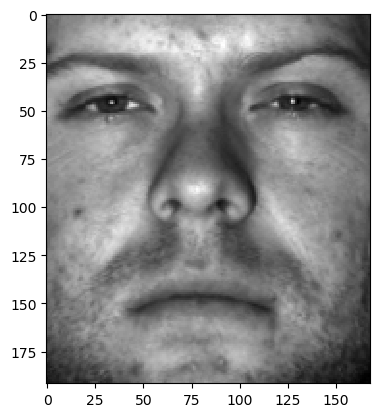

PyObject <matplotlib.image.AxesImage object at 0x7fba8298ff28>

In [29]:
imshow(test_set[1,:,:],"gray")

Nous appelons la fonction decide() pour faire la reconnaissance du visage d'une personne. Si cette personne existe ou pas dans la base de données de train. Si c'est le cas, on affiche l'image correspondante dans le train set.

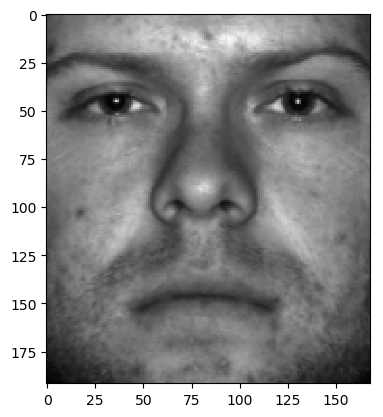

Meilleur correspondance:

"yaleB01_P00A+000E+00.pgm"

In [30]:
decide(test_set[1,:,:],train,Seuil,train_set,facedim,U,psi,n95,0.3,true)

**La reconaissance obtenue est correcte. Testons avec une personnne dont aucune image n'existe pas dans le train set.**

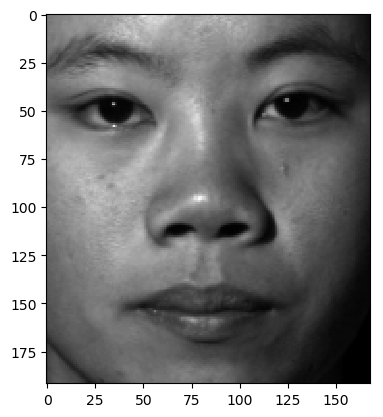

PyObject <matplotlib.image.AxesImage object at 0x7fba903834a8>

In [31]:
imshow(test_set[65,:,:],"gray")

Nous appelons encore une fois la fonction decide().

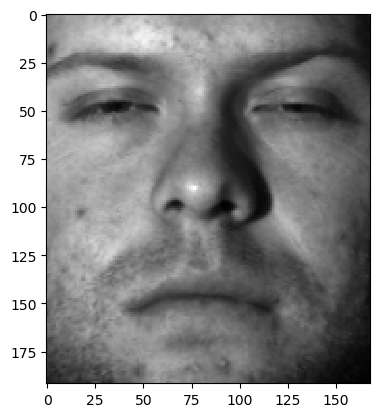

Meilleur correspondance:

"yaleB01_P00A+025E+00.pgm"

In [32]:
decide(test_set[65,:,:],train,Seuil,train_set,facedim,U,psi,n95,0.8,true)

**Nous remarquons que l'algorithme nous donne un mauvais résultat.**

Modifions alors le seuil en le faisant passer de 0.8xthreshold à 0.3xthreshold: 

In [34]:
decide(test_set[65,:,:],train,Seuil,train_set,facedim,U,psi,n95,0.3,true)

"Cette personne n'existe pas dans l'ensemble d'entrainement!"

**L'algorithme donne maintenant un bon résultat**


##### IV.1.3.  Conclusion de la méthode1
    
Le seuil proposé dans la publication de Sheifali Gupta. et al, "A New Optimized Approach to Face Recognition Using EigenFaces" $^{(5)}$ marche très bien pour les données utilisées dans ce papier mais à priori pas de la même façon sur nos données. En effet, le seuil dépend fortement des images utilisées, de leur qualité et du nombre d'exemples sélectionnés. Changer le facteur de multiplication du seuil (par exemple passage de 0.8 à 0.3) peut donner un bon résultat à la fin. Nous allons utiliser la validation croisée pour trouver le facteur de multiplication k qui minimise l'erreur sur l'ensemble de validation.

<a id="section_IV.2"></a>
#### IV.2.  Méthode 2: calcul du seuil par validation croisée: 

Nous divisons l'ensemble test en deux parties: une de validation et une autre de test (utiliser le même ensemble pour la validation et le test peut nous donner un taux d'erreur sous-estimé): 

Nous commençons par créer l'ensemble de validation

In [35]:
validation = readdir("./Validation")
validation_set,facedim,n = lireimages(validation)
validation_set = reshape(validation_set,(size(validation_set)[1],facedim[1],facedim[2]));

Puis créer l'ensemble de test qui ne contiendra pas les mêmes images que l'ensemble de validation

In [36]:
new_test = String[]
for i=1:length(test)
   if !(test[i] in validation)
        push!(new_test, test[i])
    end
end
new_test_set,facedim,n = lireimages(new_test)
new_test_set = reshape(new_test_set,(size(new_test_set)[1],facedim[1],facedim[2]));

L'étape suivante est faite pour facilier la tâche de voir la correspondance entre la personne reconnue et la personne réelle

In [37]:
finder_train = String[]
for i=1:28:length(train)
    push!(finder_train,split(train[i],"_")[1])
end

Ensuite, nous définissons la fonction *computeaccuracy* qui nous permet de calculer la précision du modèle sur la base de données de validation:

In [38]:
"""
compteaccuracy: cacul la performance du modèle dans le validation set
input : - validation_set: les arrays correspondant aux images dans le validation set
        - train: le path de toutes les photos du train set
        - Seuil: le seuil calculé précedemment
        - train_set: les arrays correspondant aux images dans le train set
        - facedim: 192*168
        - U: EigenFaces
        - psi: Moyenne des visages
        - n95: 54
        - k: paramètre entre 0.05 et 1 qui sera multiplié par le seuil
output: - retourne la précision du modèle dans le validation set
"""
function computeaccuracy(validation_set,validation,train,Seuil,train_set,facedim,U,psi,n95,k)
    accuracy = 0
    for i=1:size(validation_set,1)
        image_new = validation_set[i,:,:]
        prediction = decide(validation_set[i,:,:], train,Seuil,train_set,facedim,U,psi,n95,k)
        if prediction != "Cette personne n'existe pas dans l'ensemble d'entrainement!"
            if split(prediction,"_")[1] == split(validation[i],"_")[1]
                accuracy = accuracy + 1
            end
        else
            if !(split(validation[i],"_")[1] in finder_train)
                accuracy = accuracy + 1
            end
        end
    end
    accuracy = accuracy/size(validation_set,1)
    return accuracy
end

computeaccuracy

Définissons la fonction de validation croisée qui retourne le meilleur facteur de multiplication et la précision correspondante:

In [39]:
"""
cross_validation: prend plusieurs valeurs de k entre 0.1 et 1
input : - validation_set: les arrays correspondant aux images dans le validation set
        - train: le path de toutes les photos du train set
        - Seuil: le seuil calculé précedemment
        - train_set: les arrays correspondant aux images dans le train set
        - facedim: 192*168
        - U: EigenFaces
        - psi: Moyenne des visages
        - n95: 54
        - k: paramètre entre 0.1 et 1 qui sera multiplié par le seuil
output: - retourne le meilleur k et la performance correspondante
"""
function cross_validation(validation_set,validation,train,Seuil,train_set,facedim,U,psi,n95)
   best_accuracy = 0 
   for i=0:10:100
        if i>1
            k = 0.01*i
            acc = computeaccuracy(validation_set,validation,train,Seuil,train_set,facedim,U,psi,n95,k)
            k = @sprintf("%.1f",k)
            print("k = $k -> accuracy = $acc \n")
            if acc > best_accuracy
                best_accuracy = acc
                global best_k = k
            end
        end
   end
   return best_k, best_accuracy
end

cross_validation

In [40]:
k,accuracy = cross_validation(validation_set,validation,train,Seuil,train_set,facedim,U,psi,n95)

k = 0.1 -> accuracy = 0.2916666666666667 
k = 0.2 -> accuracy = 0.375 
k = 0.3 -> accuracy = 0.7083333333333334 
k = 0.4 -> accuracy = 0.6666666666666666 
k = 0.5 -> accuracy = 0.5416666666666666 
k = 0.6 -> accuracy = 0.5416666666666666 
k = 0.7 -> accuracy = 0.5833333333333334 
k = 0.8 -> accuracy = 0.5833333333333334 
k = 0.9 -> accuracy = 0.5833333333333334 
k = 1.0 -> accuracy = 0.5833333333333334 


("0.3", 0.7083333333333334)

Nous constatons que la valeur de k=0.3 donne la meilleure précision de 0.71%.

**Calculons maintenant la précision pour le nouvel ensemble test avec k= 0.3:**

In [43]:
k = 0.3
test_acc = computeaccuracy(new_test_set,new_test,train,Seuil,train_set,facedim,U,psi,n95,k)

0.7777777777777778

**Remarque:**  
___
    
Nous pouvons aussi augmenter le nombre de décimal qu'on utilise pour la recherche de la meilleure valeur de k, par exemple de 0.01 à 1 avec un pas de 0.01. Outre le problème du temps d'execution pour obtenir cette valeur de k, un autre problème existe. En effet, avec cette nouvelle valeur de k, on aura une meilleure accuracy, mais cette accuracy concernera le validation set seulement, notre modèle pourrait donc avoir très bien appris à reconnaître les visages sur cette base de données mais ne sera pas autant capable de le faire sur le test set par exemple si on a nouvelle personne apparaît. 

**Conclusion:**
___

Avec une méthode aussi simple que l'analyse en composantes principales, nous avons obtenue **une classification 78% correcte de 45 images de l'ensemble test.**  
Voici un exemple de classification concret:

Nous importons l'image de l'ensemble de test

In [72]:
new_test[20]

"yaleB18_P00A+020E-10.pgm"

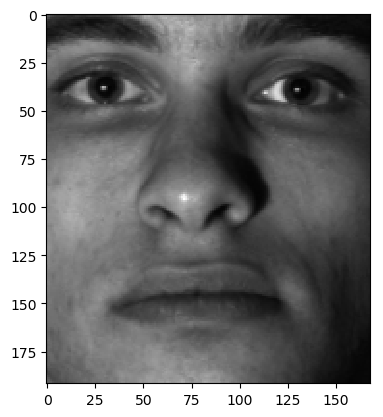

PyObject <matplotlib.image.AxesImage object at 0x7fba82585fd0>

In [73]:
imshow(new_test_set[20,:,:],"gray")

Nous appliquons la fonction decide() pour établir la reconnaissance faciale

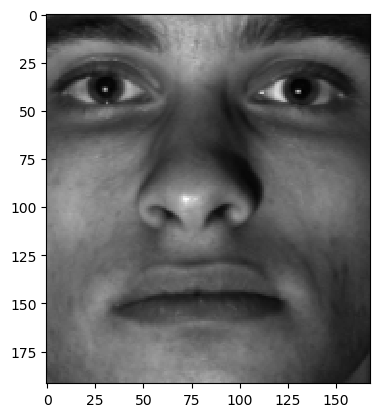

Meilleur correspondance:

"yaleB18_P00A+010E-20.pgm"

In [74]:
decide(new_test_set[20,:,:],train,Seuil,train_set,facedim,U,psi,n95,k,true)

<a id="section_V"></a>
### V. Autres utilisations de la PCA dans la vision


**Idée : Tranférer le style de peinture de Van Gogh à des images de nature.**

Nous pouvons utiliser l'analyse en composantes principales pour transférer le style de plusieurs oeuvres d'art de Van Gogh une simple image. Nous Récupérons les images des oeuvres d'art dans le dossier "Art":

In [109]:
style = readdir("./Art")

10-element Array{String,1}:
 "country-road-with-cypresses.jpg"    
 "cypresses.jpg"                      
 "houses-at-auvers.jpg"               
 "irises.jpg"                         
 "langlois-bridge-at-arles.jpg"       
 "the-mulberry-tree-in-autumn.jpg"    
 "the-starry-night-over-the-rhone.jpg"
 "the-starry-night.jpg"               
 "wheat-field-with-crows.jpg"         
 "wheat-fields-near-auvers.jpg"       

Nous créons ensuite la fonction *loadstyle* qui permet de récupérer les oeuvres d'art de Van Gogh en couleurs, c'est-à-dire que nous récupérons les pixels de chaque couleur RGB (Red- Green - Blue) dans une liste:

In [119]:
imagedim=[600 781]
function loadstyle(list)
  n=length(list)
  data_R =zeros(n,imagedim[1]*imagedim[2])
  data_G =zeros(n,imagedim[1]*imagedim[2])
  data_B =zeros(n,imagedim[1]*imagedim[2])

  for i = 1:length(list)
        im=load("Art/"*list[i])
        im = imresize(im, (600, 781))
        im=convert(Array{Float64},channelview(im))
        data_R[i,:,:] = im[1,:,:][:]
        data_G[i,:,:] = im[2,:,:][:]
        data_B[i,:,:] = im[3,:,:][:]
  end
  return data_R::Array{Float64,2},data_G::Array{Float64,2},data_B::Array{Float64,2}
end

loadstyle (generic function with 1 method)

Ensuite, nous séparons les trois channels R, G, B

In [120]:
set_R,set_G,set_B = loadstyle(style)

([0.576471 0.243137 … 0.376471 0.439216; 0.337255 0.341176 … 0.333333 0.411765; … ; 0.419608 0.396078 … 0.294118 0.384314; 0.509804 0.623529 … 0.498039 0.482353], [0.611765 0.278431 … 0.513725 0.564706; 0.533333 0.545098 … 0.403922 0.482353; … ; 0.45098 0.427451 … 0.192157 0.313725; 0.654902 0.768627 … 0.545098 0.529412], [0.670588 0.337255 … 0.329412 0.380392; 0.419608 0.439216 … 0.168627 0.254902; … ; 0.454902 0.435294 … 0.184314 0.298039; 0.717647 0.831373 … 0.34902 0.333333])

In [121]:
U_R,lambda_R,psi_R,cumvar_R = decomppca(set_R)
U_G,lambda_G,psi_G,cumvar_G = decomppca(set_G)
U_B,lambda_B,psi_B,cumvar_B = decomppca(set_B)

([0.00124691 5.33609e-5 … 0.00235057 -0.164363; 0.00157569 0.000724318 … -0.000536615 0.0253861; … ; -0.00055652 -0.000248916 … -0.000166333 -0.00059999; -0.000913453 0.000364423 … 0.000425482 -0.000137789], [54858.0, 34112.1, 28340.4, 24913.3, 21680.1, 19311.8, 14108.6, 10968.8, 8127.98, 1.21235e-26], [0.539216; 0.49098; … ; 0.221176; 0.261176], [0.253478, 0.411097, 0.542047, 0.657162, 0.757338, 0.846571, 0.911761, 0.962444, 1.0, 1.0])

In [163]:
function nbreigenstyles(cumvar::Array{Float64,1})
  N95=findall(cumvar.>0.95)
  n95=findmin(N95)[1]
  return n95::Int
end

nbreigenstyles (generic function with 1 method)

In [164]:
n95_R = nbreigenstyles(cumvar_R) # le maximum des nombres de composantes principales à utiliser pour la channel R
n95_G = nbreigenstyles(cumvar_G)
n95_B = nbreigenstyles(cumvar_B)

8

On sélectionne le maximum des nombres de composantes principales à utiliser pour chaque channel(R,G,B)

In [168]:
n95 = max(n95_R, n95_G, n95_B)

9

Visualisons les 9 premiers styles pour chaque couleur:

In [170]:
function showstyles(U::Array{Float64,2},psi::Array{Float64,2},imagedim::Array{Int})
  im=reshape(psi,imagedim[1],imagedim[2])
  figure()
  imshow(im,"gray")
  axis("off")
  figure()
  for i=1:n95
    subplot(3,3,i)
    im=U[:,i]
    Im=reshape(im,imagedim[1],imagedim[2])
    imshow(Im,"gray")
    axis("off")
  end
end

showstyles (generic function with 1 method)

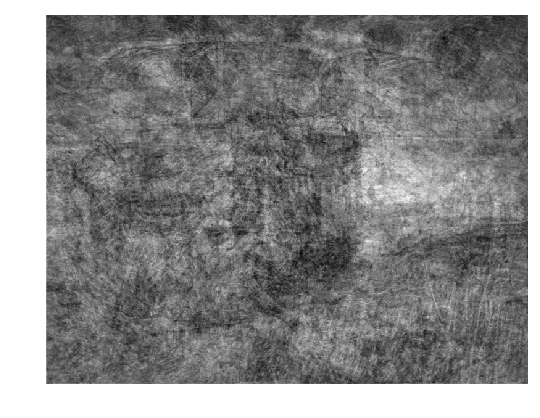

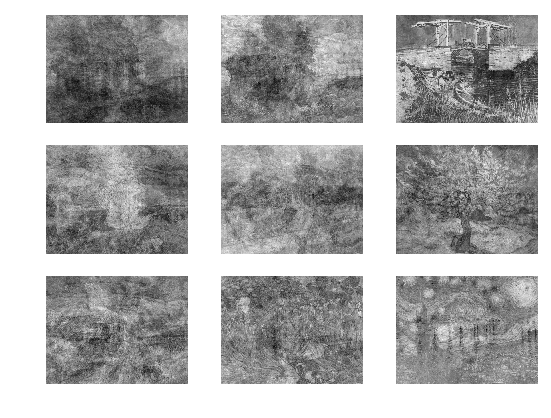

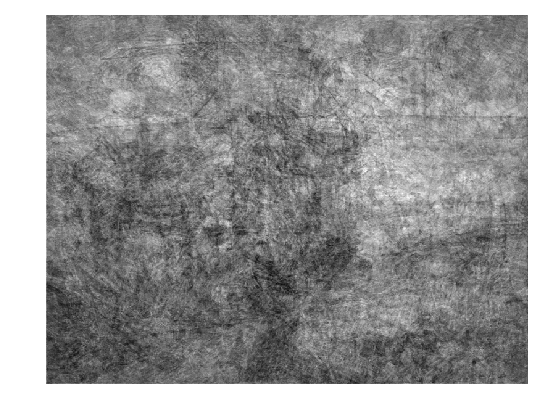

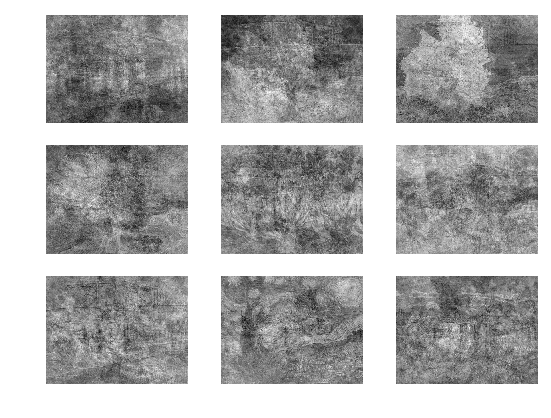

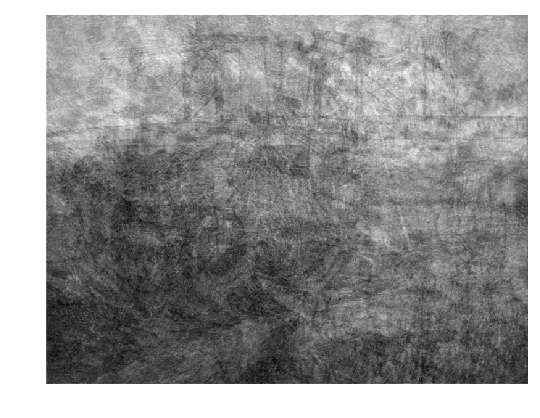

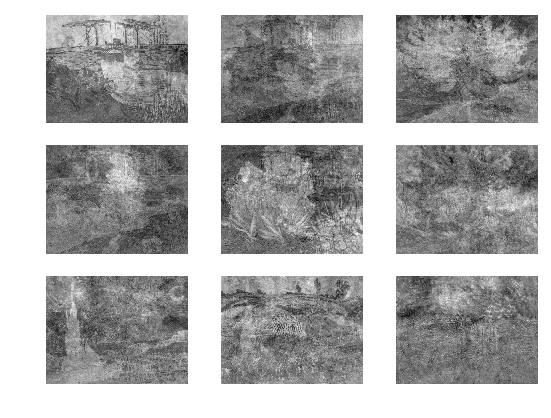

In [171]:
showstyles(U_R,psi_R,imagedim)
showstyles(U_G,psi_G,imagedim)
showstyles(U_B,psi_B,imagedim)

In [172]:
function reconstructimage(im::Array{Float64,2},U::Array{Float64,2},psi::Array{Float64,2},n::Int)
  comp = getweights(im,U,psi,n)
  recon = U[:,1:n]*comp+psi
  recon = reshape(recon,size(im))
  return recon::Array{Float64,2}
end

reconstructimage (generic function with 1 method)

On importe l'image sur laquelle on souhaite appliquer les EigenStyles et on la convertie en array de taille 600 x 781

In [206]:
im=load("./nature.jpg")
im = imresize(im, (600, 781))
im= convert(Array{Float64},channelview(im))

3×600×781 Array{Float64,3}:
[:, :, 1] =
 0.0         0.0  0.00392157  0.00392157  …  0.180392  0.290196  0.215686 
 0.00392157  0.0  0.00392157  0.00392157     0.0       0.176471  0.152941 
 0.0         0.0  0.00392157  0.00392157     0.0       0.117647  0.0666667

[:, :, 2] =
 0.0         0.00392157  0.00392157  …  0.945098  0.14902    0.176471 
 0.00784314  0.00392157  0.00392157     0.784314  0.054902   0.12549  
 0.00392157  0.00392157  0.00392157     0.788235  0.0235294  0.0392157

[:, :, 3] =
 0.00784314  0.00784314  0.00784314  …  0.478431  0.129412   0.180392 
 0.0156863   0.00784314  0.00784314     0.352941  0.0588235  0.141176 
 0.0117647   0.00784314  0.00784314     0.356863  0.0392157  0.0823529

...

[:, :, 779] =
 0.247059   0.0862745  0.0        …  0.0470588  0.117647    0.12549   
 0.0784314  0.0313725  0.0470588     0.0666667  0.0862745   0.0509804 
 0.184314   0.0784314  0.0470588     0.0        0.00784314  0.00784314

[:, :, 780] =
 0.145098  0.0313725   0.290196  0.

On reconstruit chaque channel de l'image avec les EigenStyles correspondants

In [207]:
out_R = reconstructimage(im[1,:,:], U_R, psi_R, n95)
out_G = reconstructimage(im[2,:,:], U_G, psi_G, n95)
out_B = reconstructimage(im[3,:,:], U_B, psi_B, n95)

600×781 Array{Float64,2}:
 0.64741   0.359094   0.398658   0.307141   …  0.394325  0.361579  0.561381
 0.541163  0.109111   0.118823   0.162553      0.159273  0.117547  0.29411 
 0.552472  0.159609   0.168373   0.199931      0.249988  0.195002  0.389911
 0.557316  0.151577   0.174771   0.183296      0.295776  0.243423  0.417727
 0.603052  0.1827     0.20153    0.216406      0.302194  0.261608  0.414833
 0.586405  0.226627   0.254955   0.241746   …  0.288998  0.248742  0.37616 
 0.622588  0.252992   0.27675    0.2823        0.242881  0.206826  0.369931
 0.609367  0.275087   0.293039   0.26835       0.246565  0.227447  0.394706
 0.669759  0.344208   0.349867   0.242815      0.218048  0.191459  0.373555
 0.624216  0.291017   0.356959   0.310905      0.218156  0.215684  0.385369
 0.582729  0.235935   0.341042   0.356812   …  0.22819   0.211378  0.35307 
 0.617843  0.249026   0.289317   0.290305      0.26035   0.24463   0.389486
 0.643134  0.332488   0.342531   0.302922      0.259966  0.215

In [208]:
o = zeros(3,imagedim[1],imagedim[2])
o[1,:,:] = out_R
o[2,:,:] = out_G
o[3,:,:] = out_B

600×781 Array{Float64,2}:
 0.64741   0.359094   0.398658   0.307141   …  0.394325  0.361579  0.561381
 0.541163  0.109111   0.118823   0.162553      0.159273  0.117547  0.29411 
 0.552472  0.159609   0.168373   0.199931      0.249988  0.195002  0.389911
 0.557316  0.151577   0.174771   0.183296      0.295776  0.243423  0.417727
 0.603052  0.1827     0.20153    0.216406      0.302194  0.261608  0.414833
 0.586405  0.226627   0.254955   0.241746   …  0.288998  0.248742  0.37616 
 0.622588  0.252992   0.27675    0.2823        0.242881  0.206826  0.369931
 0.609367  0.275087   0.293039   0.26835       0.246565  0.227447  0.394706
 0.669759  0.344208   0.349867   0.242815      0.218048  0.191459  0.373555
 0.624216  0.291017   0.356959   0.310905      0.218156  0.215684  0.385369
 0.582729  0.235935   0.341042   0.356812   …  0.22819   0.211378  0.35307 
 0.617843  0.249026   0.289317   0.290305      0.26035   0.24463   0.389486
 0.643134  0.332488   0.342531   0.302922      0.259966  0.215

On visualize l'image 

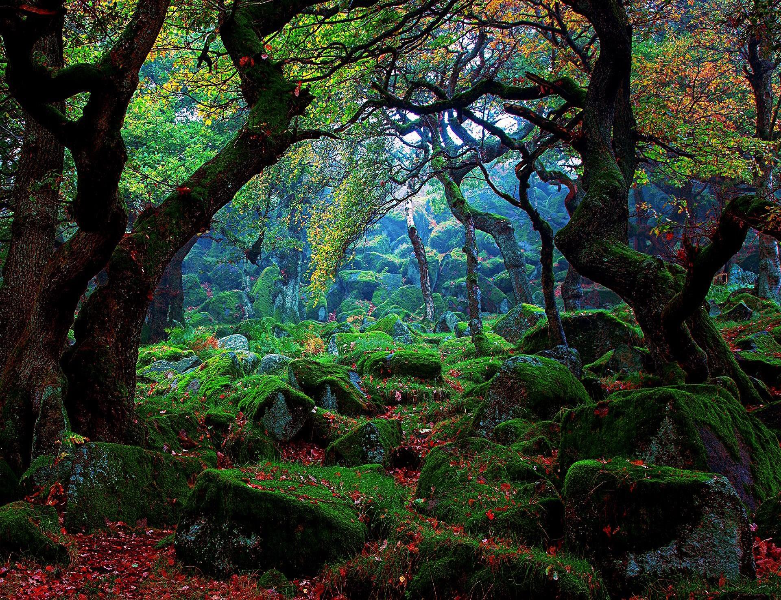

In [209]:
colorview(RGB, im)

Nous visualize alors la nouvelle image qui représente la projection de l'image "nature" dans l'espace des vecteurs propres. Voici le résultat que nous obtenons:

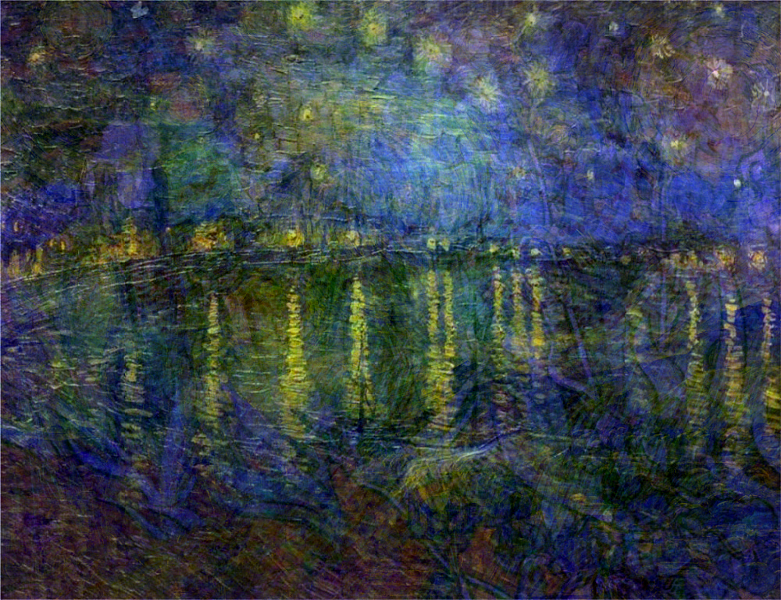

In [210]:
colorview(RGB, o)

**Remarque:**  

Une autre utilisation intéressante est la reconnaissance faciale en temps réel discutée dans la publication de Matthew A. Turk et Alex P. Pentland, "Face Recognition Using Eigenfaces"$^{(6)}$.

<a id="section_VI"></a>
### VI. Références:

(1) : http://vision.ucsd.edu/content/yale-face-database

(2) : http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf  

(3) : https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res  

(4) : https://youtu.be/_lY74pXWlS8?t=543

(5) : https://pdfs.semanticscholar.org/1e1c/fcd1da24ec87a4b59b248e826c14a82c66f8.pdf

(6) : http://www.mit.edu/~9.54/fall14/Classes/class10/Turk%20Pentland%20Eigenfaces.pdf